## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

## Directory

In [2]:
homepath = "C:/A.PROJECTS/stockprediction/"

## Data

In [3]:
# Read the CSV file
sp500_prices = pd.read_csv(homepath + 'data/sp500_timeseries.txt',sep="\t", parse_dates=['Date'],index_col='Date')
sp500_prices.drop(['ABNB'], axis=1, inplace=True)

In [4]:
def compute_returns(df):
    """
    Computes weekly, monthly, quarterly, and annual simple and log returns
    from a DataFrame of daily adjusted prices.

    Args:
        df (pd.DataFrame): DataFrame with daily adjusted prices. The index should be datetime.

    Returns:
        dict: A dictionary containing DataFrames for weekly, monthly, quarterly, and annual simple and log returns.
    """
    df.dropna(axis=1, inplace=True)
    # Ensure the index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a DatetimeIndex.")

    # Function to calculate simple returns
    def calculate_simple_returns(data):
        return data.pct_change().dropna()

    # Function to calculate log returns
    def calculate_log_returns(data):
        return np.log(data).diff().dropna()

    # Resample data and calculate simple returns
    weekly_simple_returns = calculate_simple_returns(df.resample('W').last())
    monthly_simple_returns = calculate_simple_returns(df.resample('M').last())
    quarterly_simple_returns = calculate_simple_returns(df.resample('Q').last())
    annual_simple_returns = calculate_simple_returns(df.resample('Y').last())

    # Resample data and calculate log returns
    weekly_log_returns = calculate_log_returns(df.resample('W').last())
    monthly_log_returns = calculate_log_returns(df.resample('M').last())
    quarterly_log_returns = calculate_log_returns(df.resample('Q').last())
    annual_log_returns = calculate_log_returns(df.resample('Y').last())

    return {
        'weekly_simple': weekly_simple_returns,
        'monthly_simple': monthly_simple_returns,
        'quarterly_simple': quarterly_simple_returns,
        'annual_simple': annual_simple_returns,
        'weekly_log': weekly_log_returns,
        'monthly_log': monthly_log_returns,
        'quarterly_log': quarterly_log_returns,
        'annual_log': annual_log_returns
    }

In [5]:
rets = compute_returns(sp500_prices)
rets['weekly_log'].shape

(261, 462)

## PCA clustering

Explained variance by top 5 components: [0.09490474 0.08319444 0.04187378 0.02760561 0.02722505]


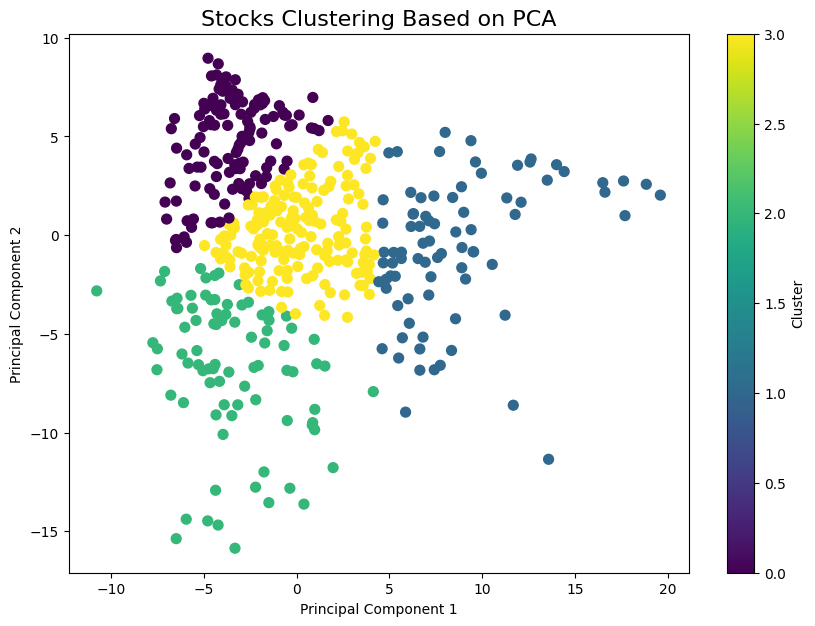

Cluster 0: ABBV, ABT, AEE, AEP, ALL, AMCR, AMT, AWK, LNT, MO, AJG, AMGN, AON, ATO, AZO, BAX, BDX, T, CAG, CB, CBOE, CHD, CHTR, CI, CL, CLX, CMCSA, CME, CMS, CNC, CNP, COR, CSCO, KO, CCI, COST, CVS, DG, DHR, DLR, ED, D, DLTR, DPZ, DTE, DUK, EA, EIX, ELV, EQIX, ERIE, ETR, ES, EVRG, EXC, FDS, FE, GILD, GIS, HRL, HSY, HUM, INCY, JKHY, JNJ, K, KDP, KHC, KMB, KR, LH, LLY, LMT, MAA, MCD, MCK, MDLZ, MKC, MMC, MNST, MOH, MRK, NEE, NEM, NI, NOC, ORLY, PEG, PEP, PFE, PG, PGR, PM, PNW, PPL, PSA, DGX, O, REGN, ROL, ROP, RSG, SBAC, SJM, SRE, SO, STE, TMO, TMUS, TSCO, TRV, TSN, UNH, VRSK, VRSN, VRTX, VZ, WRB, WEC, WM, WMT, WTW, XEL, ZTS
Cluster 1: AIG, ALB, AXP, APA, APTV, BAC, BKR, C, CE, CF, CFG, COP, CVX, SCHW, CTRA, CTVA, DAL, DFS, DVN, FANG, DOW, EMN, EOG, EQT, EXPE, F, FCX, FITB, GE, XOM, GM, HAL, HES, HST, HWM, HBAN, IVZ, JPM, KEY, KIM, KMI, LYB, LYV, MPC, MTB, MAR, MET, MGM, MHK, MOS, NCLH, NUE, OKE, OXY, PARA, PFG, PNC, PRU, PSX, RCL, RF, RJF, RL, SLB, SPG, LUV, STLD, STT, SYF, TPL, TPR, TRG

In [36]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

df = rets['weekly_log']
stock_names = df.columns

# Step 1: Normalize the data (transpose before scaling)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.T).T # Scale each stock's returns

# Step 2: Apply PCA
pca = PCA(n_components=5)  # Project into 5 principal components
pca_result = pca.fit_transform(scaled_data.T) # PCA on stocks
print(f"Explained variance by top 5 components: {pca.explained_variance_ratio_}")

# Use the first 2 components for visualization
pca_data_2D = pca_result[:, :2]

# Step 3: Cluster using K-Means
n_clusters = 4  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(pca_data_2D)

# Create a DataFrame for the PCA results and cluster assignments
pca_df = pd.DataFrame(pca_result)
pca_df['Cluster'] = clusters
pca_df['Stock'] = stock_names

# Step 4: Visualize the Clusters
plt.figure(figsize=(10, 7))
plt.scatter(pca_data_2D[:, 0], pca_data_2D[:, 1], c=clusters, cmap="viridis", s=50)
plt.title("Stocks Clustering Based on PCA", fontsize=16)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()


ClusterList_PCA = []
# Step 5: List clusters
for cluster in range(n_clusters):
    cluster_stocks = pca_df[pca_df['Cluster'] == cluster]['Stock']
    ClusterList_PCA.append(cluster_stocks)
    print(f"Cluster {cluster}: {', '.join(cluster_stocks.values)}")
ClusterDict_PCA = {
    'Cluster01':ClusterList_PCA[0],
    'Cluster02':ClusterList_PCA[1],
    'Cluster03':ClusterList_PCA[2],
    'Cluster04':ClusterList_PCA[3]
}

In [35]:
len(ClusterList_PCA)
ClusterDict_PCA['Cluster01']

1      ABBV
2       ABT
5       AEE
6       AEP
13      ALL
       ... 
449      WM
451     WMT
453     WTW
456     XEL
461     ZTS
Name: Stock, Length: 124, dtype: object